# Guava Fruit Disease Classification

## Data Loading

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d asadullahgalib/guava-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.52G/1.52G [01:12<00:00, 21.7MB/s]
100% 1.52G/1.52G [01:12<00:00, 22.5MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/guava-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [24]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
dataset_dir = '/content/GuavaDiseaseDataset/GuavaDiseaseDataset'

In [12]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

## Data Visualization

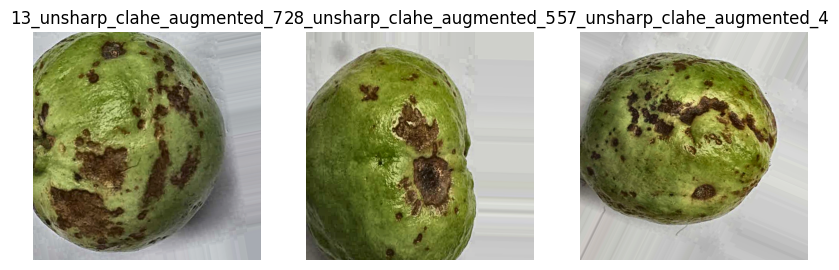

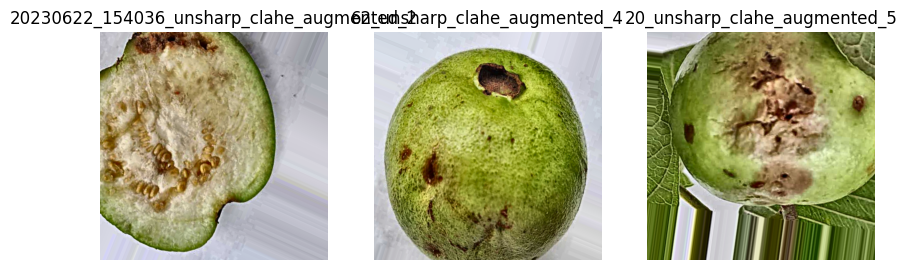

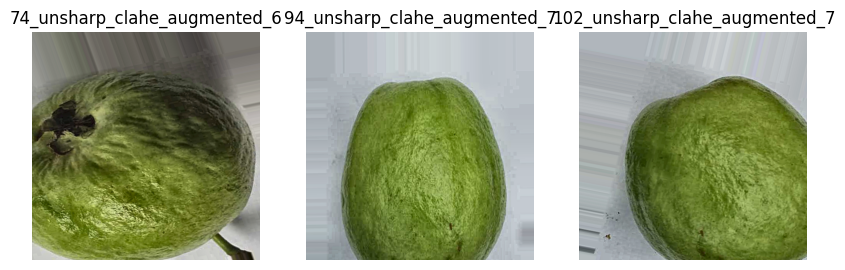

In [13]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def display_random_images_from_class(class_dir, num_images=5):

    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)

    plt.figure(figsize=(10, 10))
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(class_dir, img_file)
        img = load_img(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file.split('.')[0])
    plt.show()

display_random_images_from_class(os.path.join(train_dir, 'Anthracnose'), 3)
display_random_images_from_class(os.path.join(train_dir, 'fruit_fly'), 3)
display_random_images_from_class(os.path.join(train_dir, 'healthy_guava'), 3)

## Data Preprocessing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# Data Augmentation

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical')

Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


## Model Building

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 output classes (healthy, fruit fly, anthracnose)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 492032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      62,980,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,073,859 (240.61 MB)

 Trainable params: 63,073,859 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.4389 - loss: 4.4258 - val_accuracy: 0.7285 - val_loss: 0.6253
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.6992 - loss: 0.6574 - val_accuracy: 0.8715 - val_loss: 0.3823
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7574 - loss: 0.6085 - val_accuracy: 0.8252 - val_loss: 0.5191
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8352 - loss: 0.4918 - val_accuracy: 0.8821 - val_loss: 0.2861
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8901 - loss: 0.3063 - val_accuracy: 0.9099 - val_loss: 0.2168
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.8811 - loss: 0.3568 - val_accuracy: 0.8411 - val_loss: 0.4929
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9046 - loss: 0.2789 - val_accuracy: 0.9126 - val_loss: 0.2020
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9177 - loss: 0.2371 - val_accuracy: 0.9258 - val_loss: 0.

## Model Evaluation

In [21]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8856 - loss: 0.2823
Test Loss = 0.2702578008174896
Test Accuracy = 0.9083769917488098


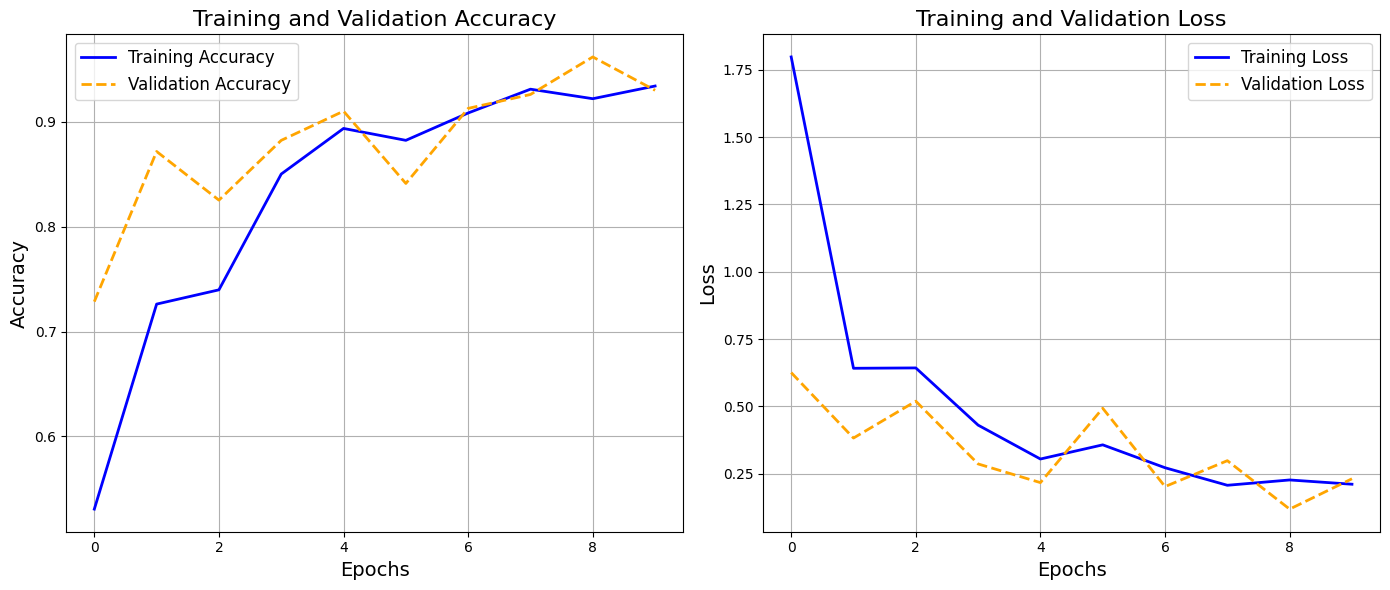

In [22]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)